<a href="https://www.kaggle.com/code/nikhil1e9/s3-e20-eda-fe-modeling?scriptVersionId=150554377" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview of the problem

The dataset contains open-source emissions data (from [Sentinel-5P](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p) satellite observations) The challenge is to predict carbon emissions across Rwanda from the given data

The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and the task is to predict the CO2 emissions data for 2022 through November. Each year includes weekly data. There are seven main features which were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature contain sub features such as column_number_density which is the vertical column density at ground level etc.

<!--
<img src="https://geographical.co.uk/wp-content/uploads/carbon-dioxide-emissions-title-1200x800.jpg" width="600" height="600">
-->
### NO2 concentrations across the globe as observed from the satellite
![](https://developers.google.com/static/earth-engine/images/datasets/copernicus_s5p_no2_1280_856.jpg)

#### Source: https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p

# Domain knowledge

Here is a brief summary of the pollutants given in the dataset

- **Sulfur dioxide (SO2)** enters the Earth's atmosphere through both natural and anthropogenic processes. Only about 30% of the emitted SO2 comes from natural sources; the majority is of anthropogenic origin. SO2 emissions adversely affect human health and air quality. SO2 has an effect on climate through radiative forcing, via the formation of sulfate aerosols.

- **Carbon monoxide (CO)** is an important atmospheric trace gas for understanding tropospheric chemistry. In certain urban areas, it is a major atmospheric pollutant. Main sources of CO are combustion of fossil fuels, biomass burning, and atmospheric oxidation of methane and other hydrocarbons.

- **Nitrogen oxides (NO2 and NO)** are important trace gases in the Earth's atmosphere, present in both the troposphere and the stratosphere. They enter the atmosphere as a result of anthropogenic activities (notably fossil fuel combustion and biomass burning) and natural processes (wildfires, lightning, and microbiological processes in soils). Here, NO2 is used to represent concentrations of collective nitrogen oxides.

- **Formaldehyde (HCHO)** is an intermediate gas in almost all oxidation chains of non-methane volatile organic compounds (NMVOC), leading eventually to CO2. The major HCHO source in the remote atmosphere is CH4 oxidation. Over the continents, the oxidation of higher NMVOCs emitted from vegetation, fires, traffic and industrial sources results enhancements of the HCHO levels.

- **Absorbing Aerosol Index (AAI)** is based on wavelength-dependent changes in Rayleigh scattering in the UV spectral range for a pair of wavelengths. When the AAI is positive, it indicates the presence of UV-absorbing aerosols like dust and smoke. It is useful for tracking the evolution of episodic aerosol plumes from dust outbreaks, volcanic ash, and biomass burning.

- **Ozone (O3)** layer shields the biosphere from dangerous solar ultraviolet radiation. In the troposphere, it acts as an efficient cleansing agent, but at high concentration it also becomes harmful to the health of humans, animals, and vegetation. Ozone is also an important greenhouse-gas contributor to ongoing climate change.

# Initial Setup

In [1]:
# Load required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import folium

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid", {"axes.facecolor": ".8"})

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load dataset files
for dirname, _, filenames in os.walk('/kaggle/input'):
    filepath = []
    for filename in filenames:
        filepath.append(os.path.join(dirname, filename))
print(filepath)
sub = pd.read_csv(filepath[0])
train = pd.read_csv(filepath[1])
test = pd.read_csv(filepath[2])

['/kaggle/input/playground-series-s3e20/sample_submission.csv', '/kaggle/input/playground-series-s3e20/train.csv', '/kaggle/input/playground-series-s3e20/test.csv']


# Exploring the data

In [3]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [4]:
print(train.shape, test.shape)

(79023, 76) (24353, 75)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      24353 non-null  object 
 1   latitude                                                  24353 non-null  float64
 2   longitude                                                 24353 non-null  float64
 3   year                                                      24353 non-null  int64  
 4   week_no                                                   24353 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  18211 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              18211 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            18211 non-null  float64
 8   SulphurDioxide_c

In [7]:
train.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


In [8]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

## Looking at null values

In [9]:
train.isnull().sum().unique(),\
test.isnull().sum().unique()

(array([    0, 14609,  2122, 18320,  7277,   539,   548, 78584,   484]),
 array([    0,  6142,  1337,  5655,  3393,   147, 22260,   166]))

Training data contains many null values. It can be seen that the values are constant among column categories. 

In [10]:
# Display null values across different columns
def null_value_percent(df):
    null_df = pd.DataFrame(df.isnull().sum().reset_index().groupby(0).index.first().reset_index())
    null_df.rename(columns={0: 'null_values', 'index': 'column'}, inplace=True)
    null_df['column_category'] = null_df['column'].apply(lambda x: x.split('_')[0])
    null_df['null_percent'] = null_df['null_values']*100/len(df)
    return null_df.iloc[:, 2:]

train_null = null_value_percent(train) 
test_null = null_value_percent(test)
ozone = ['Ozone', test_null.loc[1, 'null_percent']]
test_null.loc[len(test_null)] = ozone
print("Null values in Training data\n")
display(train_null)
print("Null values in Test data\n")
display(test_null)

Null values in Training data



,column_category,null_percent
0,ID,0.000000
1,Cloud,0.612480
2,UvAerosolIndex,0.682080
3,Ozone,0.693469
4,CarbonMonoxide,2.685294
5,Formaldehyde,9.208711
6,SulphurDioxide,18.487023
7,NitrogenDioxide,23.183124
8,UvAerosolLayerHeight,99.444466


Null values in Test data



,column_category,null_percent
0,ID,0.000000
1,UvAerosolIndex,0.603622
2,Cloud,0.681641
3,CarbonMonoxide,5.490083
4,Formaldehyde,13.932575
5,NitrogenDioxide,23.220958
6,SulphurDioxide,25.220712
7,UvAerosolLayerHeight,91.405576
8,Ozone,0.603622


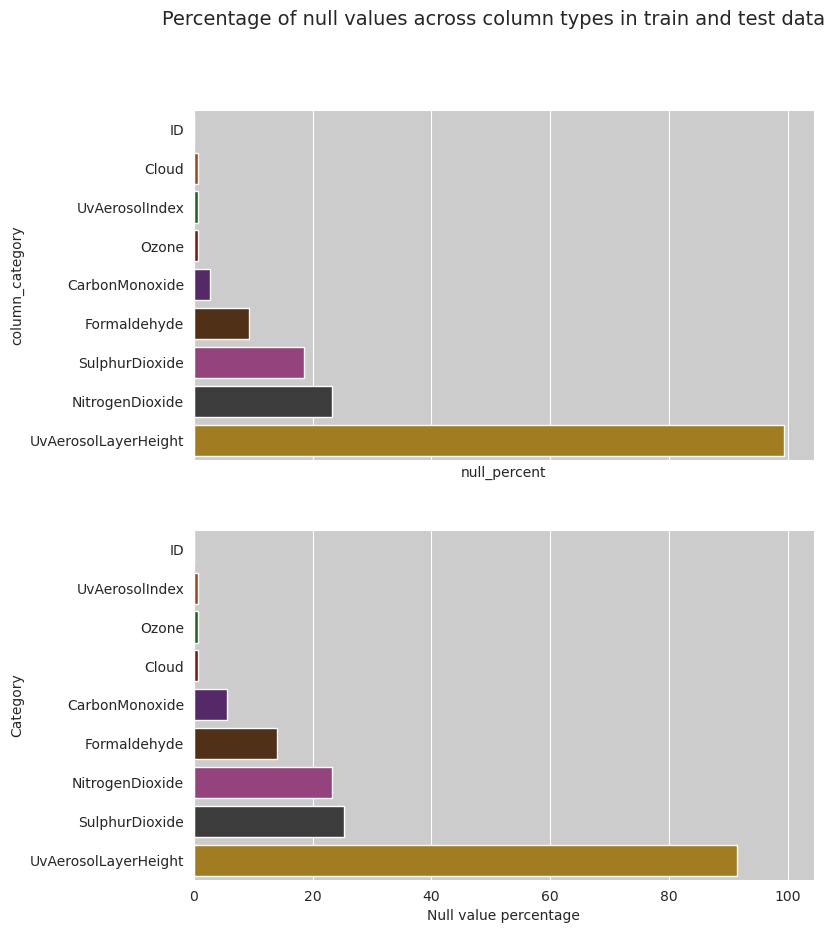

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

sns.barplot(x='null_percent', 
            y='column_category', 
            data=train_null.sort_values('null_percent'), 
            palette='dark', 
            ax=ax1)

sns.barplot(x='null_percent', 
            y='column_category', 
            data=test_null.sort_values('null_percent'), 
            palette='dark', 
            ax=ax2)

plt.xlabel("Null value percentage")
plt.ylabel("Category")
plt.suptitle("Percentage of null values across column types in train and test data", fontsize=14)
plt.show()

### Observations:
- #### UvAerosolLayerHeight category has close to 100 % null values.
- #### NO2 and SO2 columns have close to 20% and Formaldehyde columns have nearly 10% null values
- #### Rest columns don't have much null values

It would be good to remove UvAerosolLayerHeight columns as these have very large number of missing values.

In [12]:
# Dropping UvAerosolLayerHeight columns
null_cols = [col for col in train.columns if col.startswith('UvAerosolLayerHeight')]
train.drop(null_cols, axis=1, inplace=True)
test.drop(null_cols, axis=1, inplace=True)

# Data visualization

## Geographical map

In [13]:
# This code has been taken from the competition starter notebook 
# https://www.kaggle.com/code/inversion/getting-started-eda

# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)

# Create point geometries
geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-0.510,29.290,train,POINT (29.29000 -0.51000)
1,-0.528,29.472,train,POINT (29.47200 -0.52800)
2,-0.547,29.653,train,POINT (29.65300 -0.54700)
3,-0.569,30.031,train,POINT (30.03100 -0.56900)
4,-0.598,29.102,train,POINT (29.10200 -0.59800)


In [14]:
# This code has been taken from the competition starter notebook 
# https://www.kaggle.com/code/inversion/getting-started-eda

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

## Heatmap

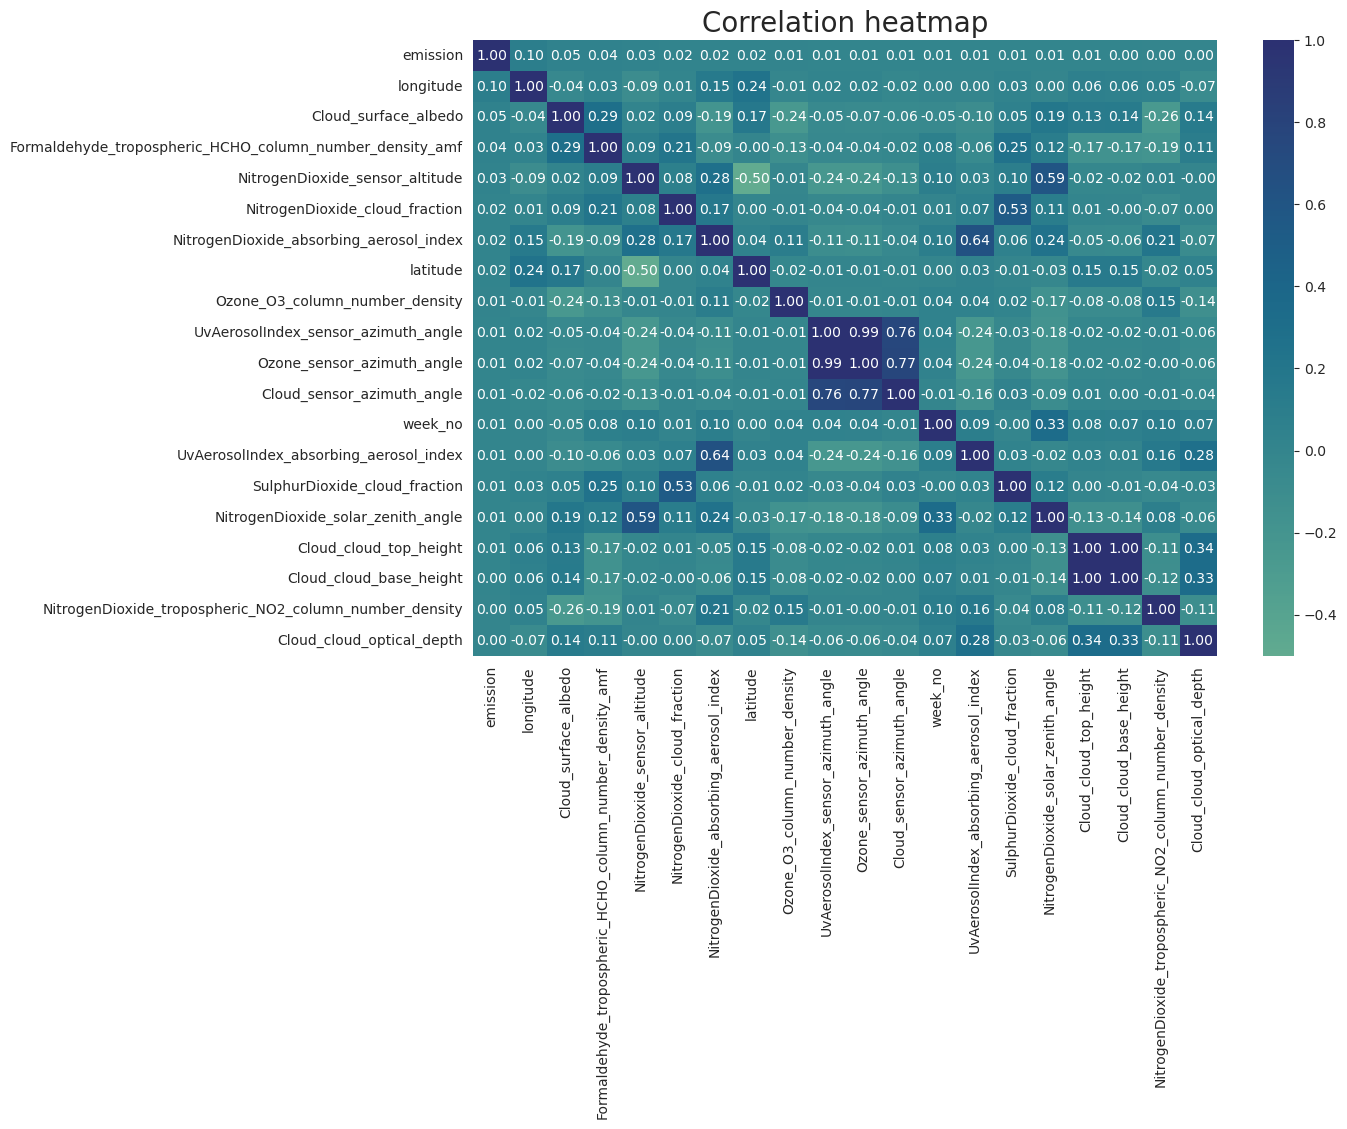

In [15]:
# Correlation of features with emission
corr_df = pd.DataFrame(train.corr()['emission'].sort_values(ascending=False))
corr = train[corr_df.index[:20]].corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, cmap='crest', annot = True, fmt='.2f', center = 0)
plt.title('Correlation heatmap', fontsize = 20)
plt.show()

## Histogram

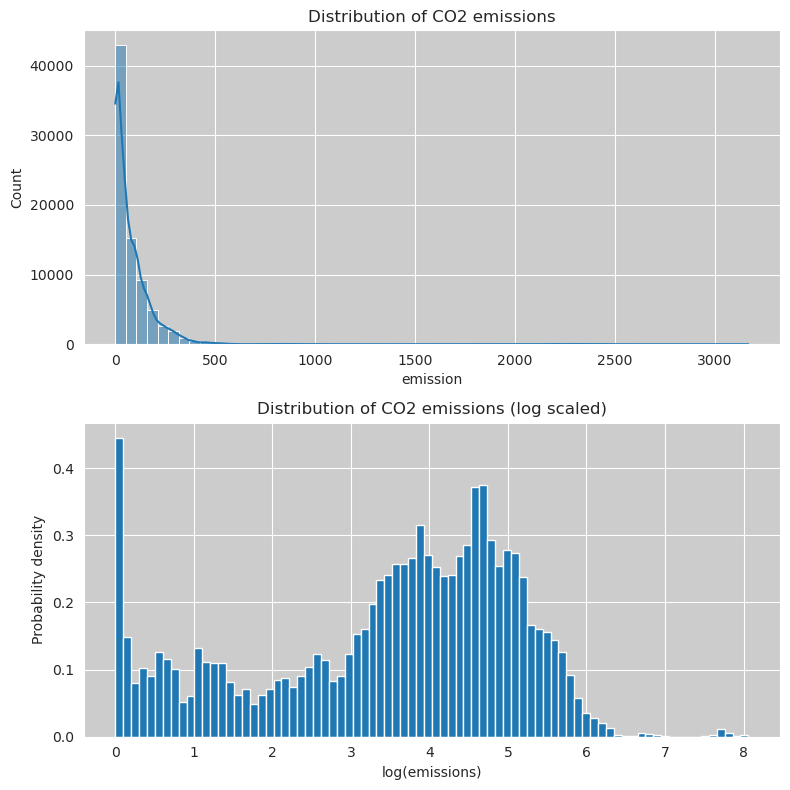

In [16]:
# Visualizing emissions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sns.histplot(x='emission', data=train, bins=60, kde=True, ax=ax1)
ax1.set_title("Distribution of CO2 emissions")
plt.hist(x=np.log1p(train['emission']), bins=80, density=True)
ax2.set_title("Distribution of CO2 emissions (log scaled)")
ax2.set_xlabel("log(emissions)")
ax2.set_ylabel("Probability density")
plt.tight_layout()
plt.show()

### Observation:
- #### The distribution of CO2 emissions looks to be a right-skewed distribution
- #### After applying log transformation it adjusts to a somewhat normal distribution

## Stripplot

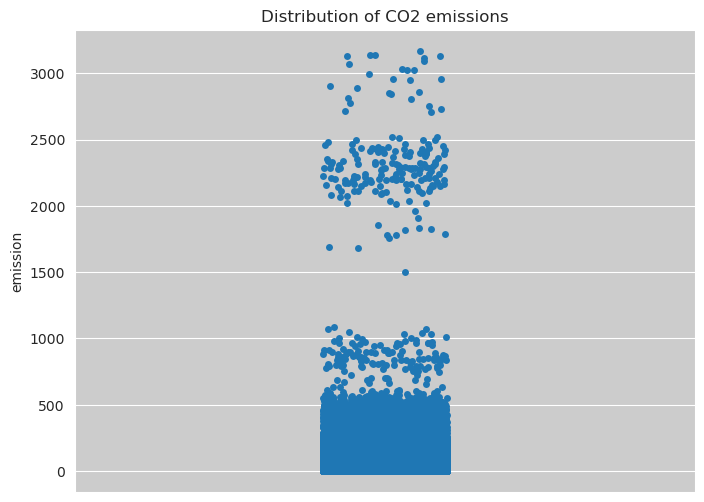

In [17]:
plt.figure(figsize=(8,6))
sns.stripplot(y='emission', data=train)
plt.title("Distribution of CO2 emissions")
plt.show()

### Observation: 
#### CO2 emissions column has a large number of outliers. This means CO2 emissions detected are not high most of the time.

In [18]:
# Number of datapoints for each unique location
train.groupby(['latitude', 'longitude']).emission.count().reset_index()

,latitude,longitude,emission
0,-3.299,30.301,159
1,-3.287,29.713,159
2,-3.174,29.926,159
3,-3.161,28.839,159
4,-3.153,30.347,159
...,...,...,...
492,-0.598,29.102,159
493,-0.569,30.031,159
494,-0.547,29.653,159
495,-0.528,29.472,159


### Observation:
#### There are 497 unique locations with each location containing 159 datapoints

## Average CO2 emissions

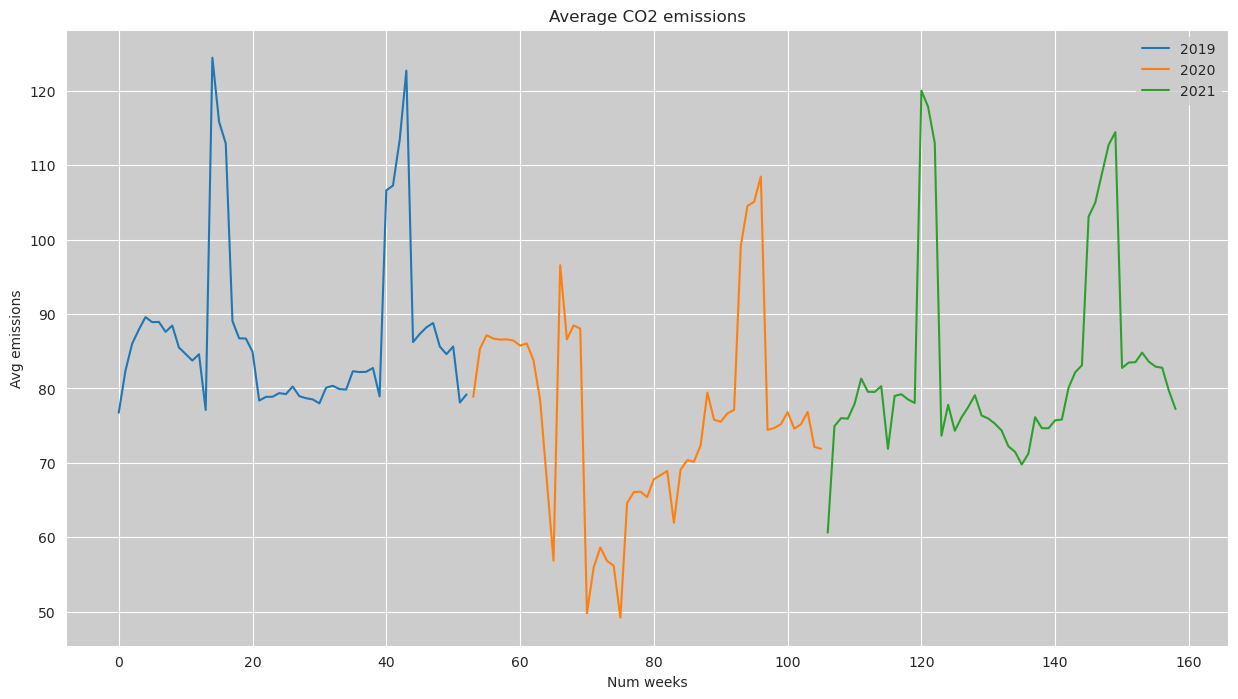

In [19]:
# Plot average CO2 emissions across the whole training data
plt.figure(figsize=(15,8))

train.groupby(['year', 'week_no']).emission.mean().reset_index().groupby('year').emission.plot()

plt.title("Average CO2 emissions")
plt.xlabel("Num weeks")
plt.ylabel("Avg emissions")

plt.legend()
plt.show()

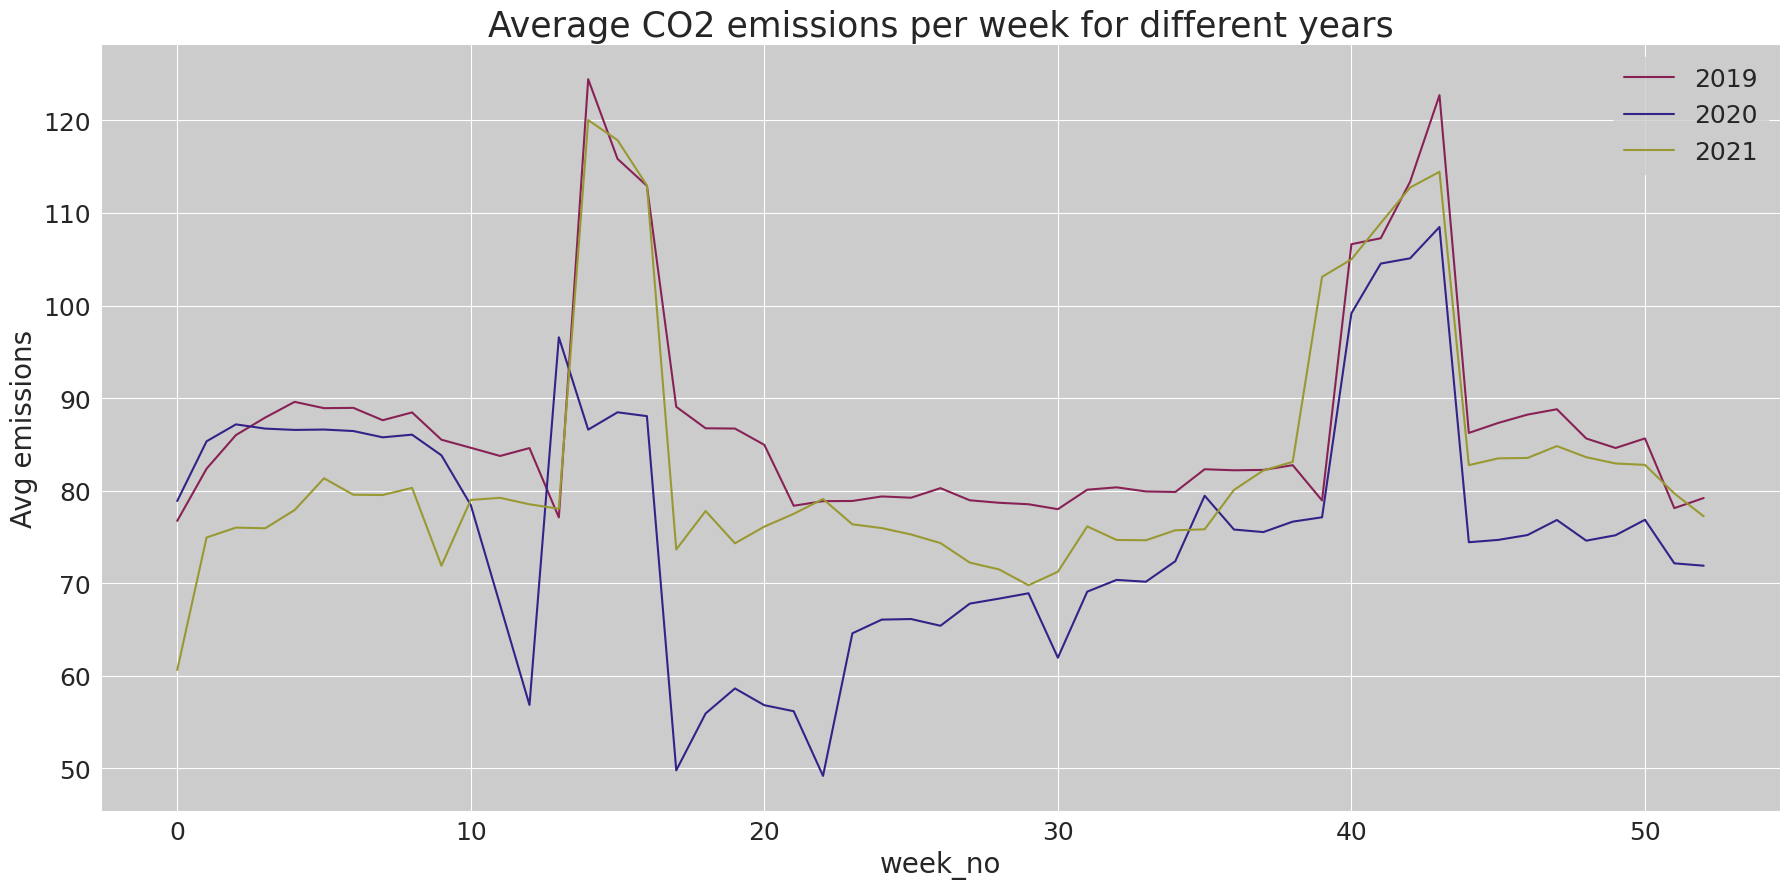

In [20]:
plt.figure(figsize=(18,9))
colors = ['#882255','#332288', '#999933']

for i, year in enumerate(train.year.unique()):
    train[train['year'] == year].groupby(['week_no'])['emission'].mean().plot(color=colors[i])
    
plt.xlabel("week_no", fontsize=20)
plt.ylabel("Avg emissions", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Average CO2 emissions per week for different years", fontsize=25)

plt.legend(train.year.unique(), fontsize=18)
plt.tight_layout()
plt.show()

### Observation:
- #### 2020 has the lowest mean emissions overall due to COVID-19 pandemic.
- #### 2019 and 2021 have somewhat similar trend for emissions.

In [21]:
# train.groupby(['latitude', 'longitude']).emission.mean().plot()

In [22]:
# Create location column by combining latitude and longitude
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]
train.groupby('location').emission.mean().sort_values(ascending=False)[:10]

location
-2.378_29.222    2233.431628
-2.079_29.321    1221.886518
-1.346_31.254     475.289138
-0.956_30.744     455.398039
-1.342_31.358     409.606870
-2.441_28.959     395.499449
-2.599_29.801     353.031771
-1.847_30.953     347.017595
-2.293_29.507     336.199968
-1.889_29.611     324.808862
Name: emission, dtype: float64

### Observation:
#### 2 locations have very high average CO2 emissions. Let us look at these separately.

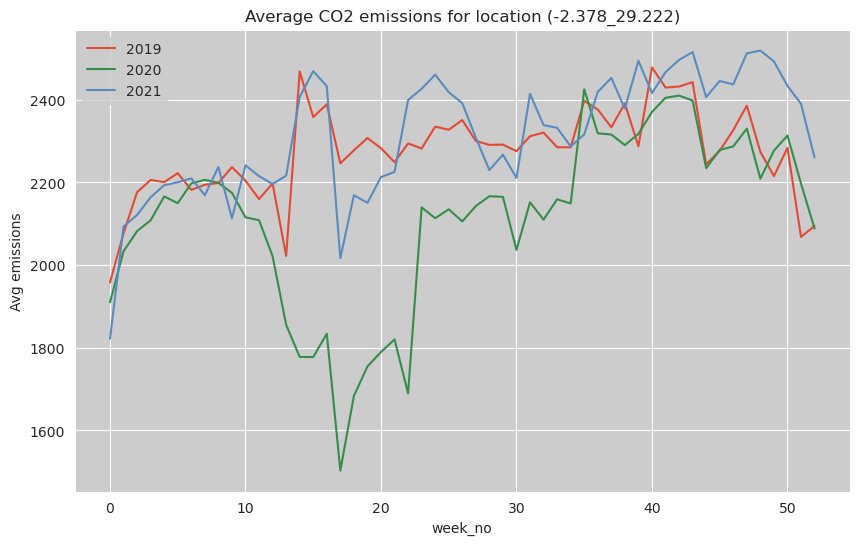

In [23]:
def plot_location(loc):
    plt.figure(figsize=(10,6))
    colors = ['#e34933', '#358e48', '#588cc0']

    # CO2 emissions for a specific location
    for i, year in enumerate(train.year.unique()):
        train[train['location'] == loc].groupby(['year', 'week_no']).emission.mean().loc[year].plot(color=colors[i])

    plt.ylabel("Avg emissions")
    plt.title(f"Average CO2 emissions for location ({loc})")
    plt.legend(train.year.unique())
    plt.show()
    
plot_location('-2.378_29.222')

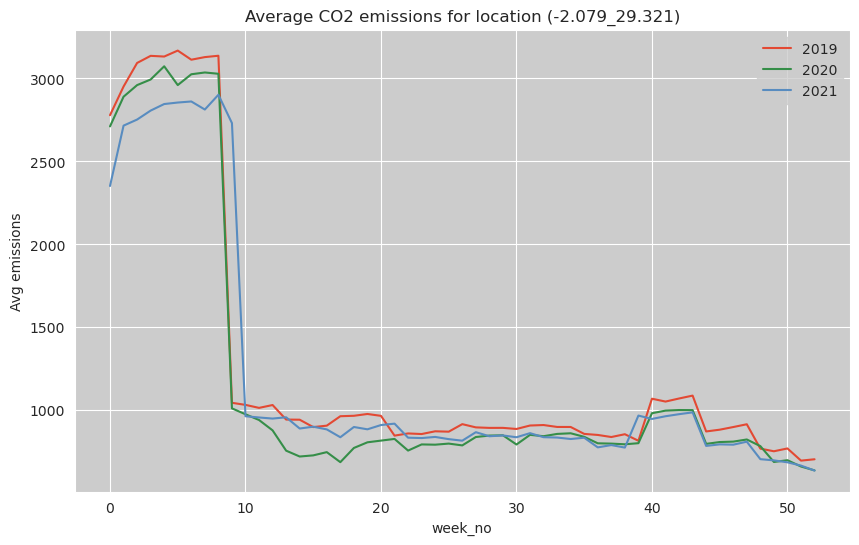

In [24]:
plot_location('-2.079_29.321')

### Observation:
- #### The first location shows a similar trend in emissions as the full train data
- #### The second location shows a strange trend where the emissions are very high for the first 9 weeks of the year and then drop down to a considerably low amount. 

## Variation between train and test data

In [25]:
pollutants = {'SO2': 'SulphurDioxide', 
              'CO': 'CarbonMonoxide', 
              'NO2': 'NitrogenDioxide', 
              'HCHO': 'Formaldehyde', 
              'UVAI': 'UvAerosolIndex', 
              'O3': 'Ozone', 
              'CLD': 'Cloud'}

def plot_dist(pollutant):
    pollutant_train = train.loc[:, train.columns.str.startswith(pollutant)]
    pollutant_test = test.loc[:, test.columns.str.startswith(pollutant)]
    x = pollutant_train.shape[1]
    x = int(np.ceil(x/3))
    fig, axes = plt.subplots(x,3,figsize=(12,x*2))   
    fig.tight_layout()
    axes = axes.flatten()

    for i, col in enumerate(pollutant_train.columns):
        sns.histplot(data=train, x=pollutant_train[col], color='red', label='train', ax=axes[i])
        sns.histplot(data=test, x=pollutant_test[col], color='purple', label='test', ax=axes[i])
        axes[i].legend()
        
    for j in range(len(pollutant_train.columns), len(axes)):
        axes[j].axis('off')

    plt.show()

### Sulphur Dioxide

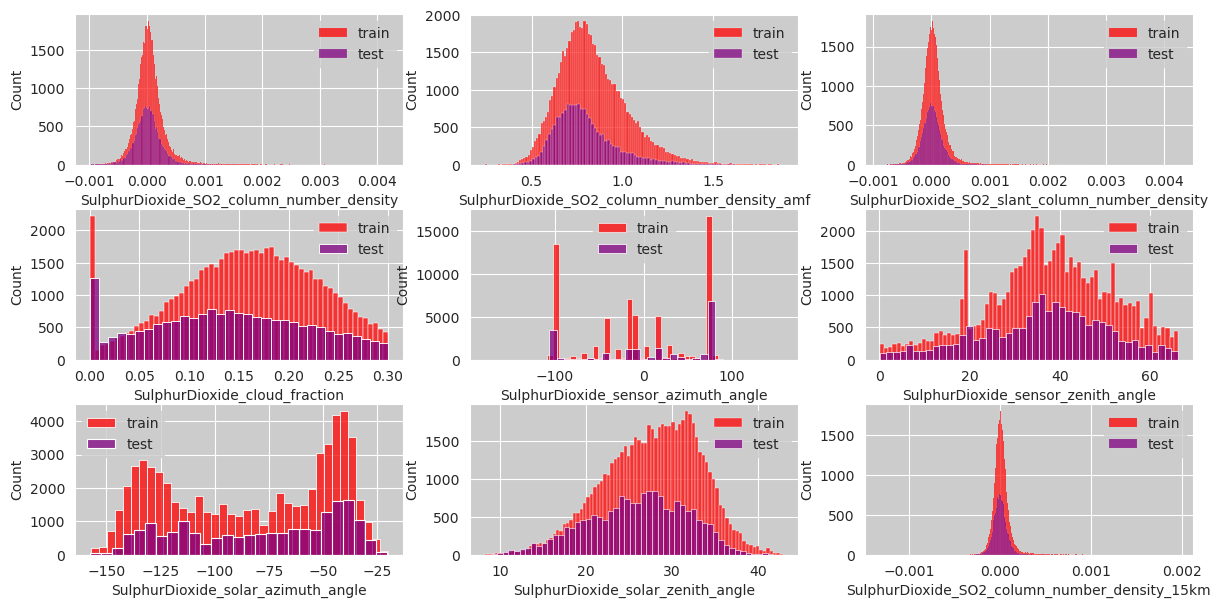

In [26]:
# Distribution of SO2 columns
plot_dist(pollutants['SO2'])

### Carbon Monoxide

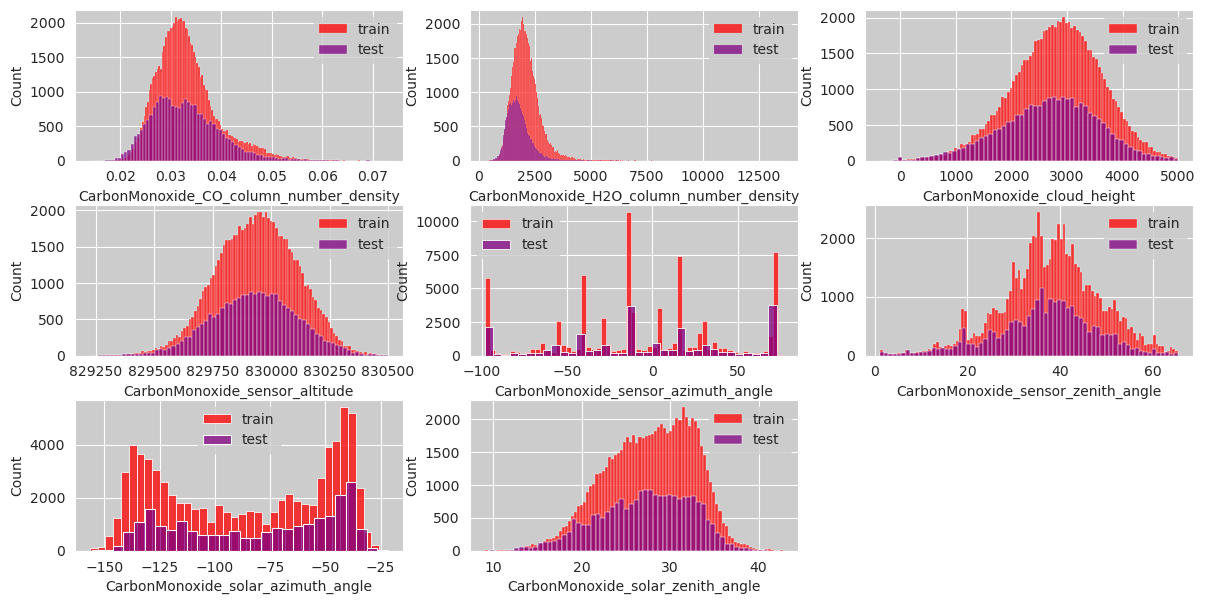

In [27]:
# Distribution of CO columns
plot_dist(pollutants['CO'])

### Nitrogen Dioxide

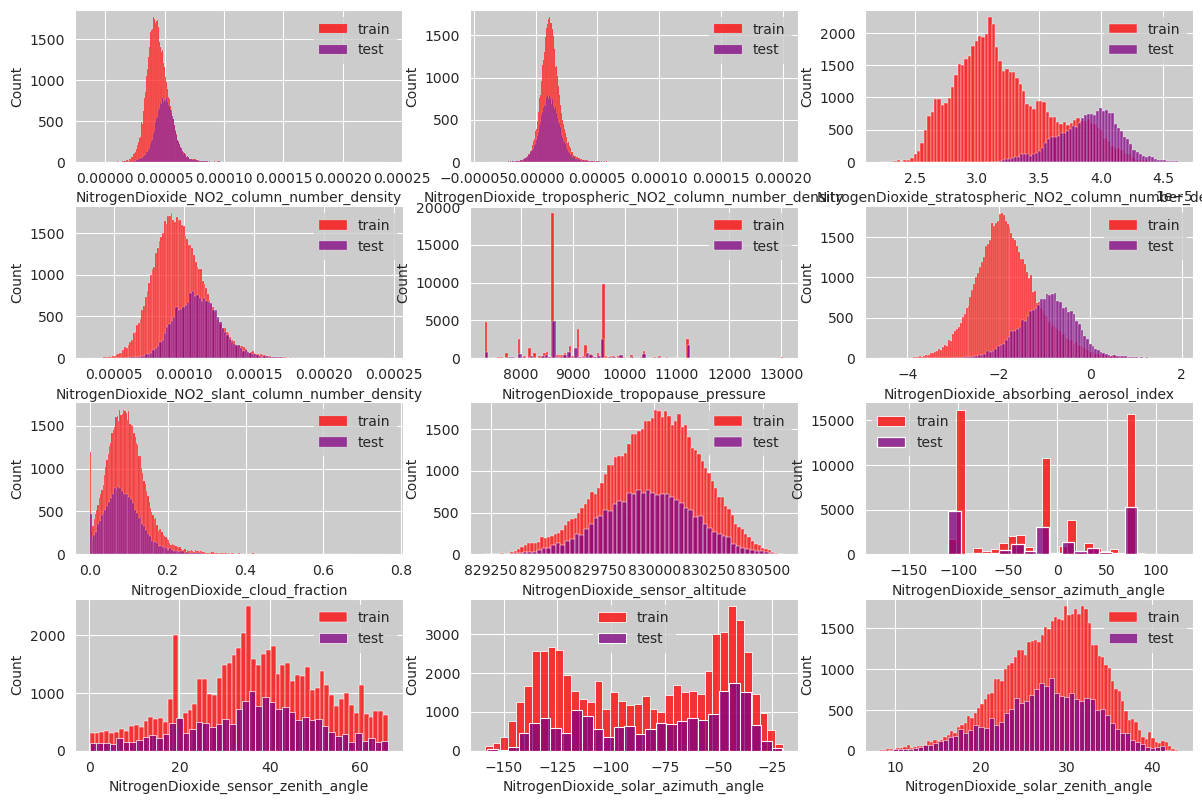

In [28]:
# Distribution of NO2 columns
plot_dist(pollutants['NO2'])

### Formaldehyde

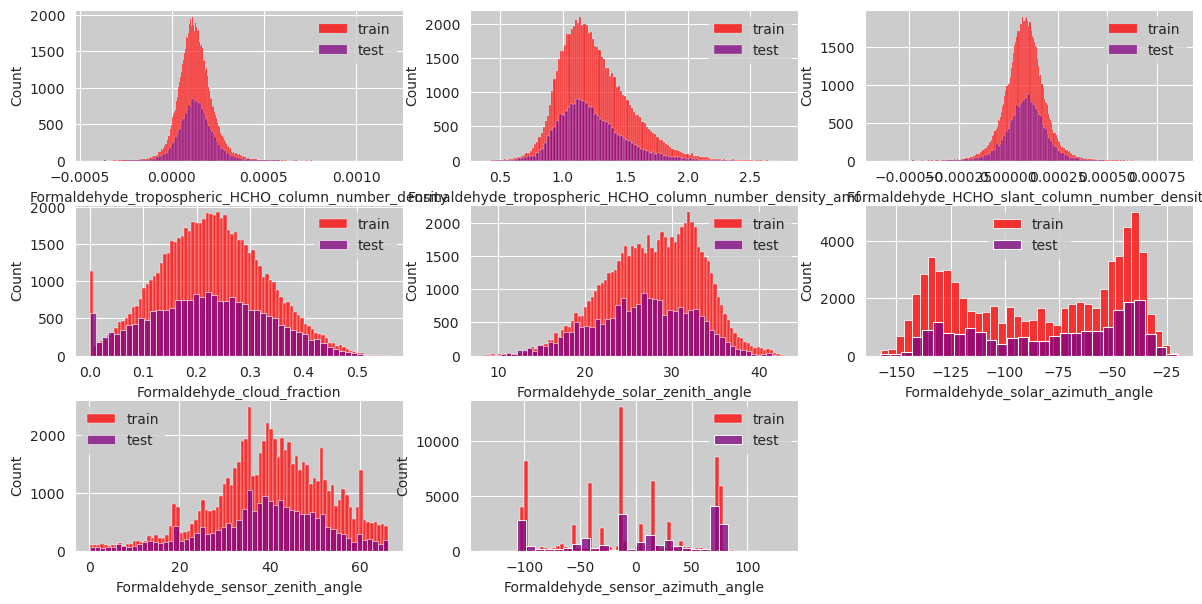

In [29]:
# Distribution of Formaldehyde columns
plot_dist(pollutants['HCHO'])

### UV Aerosol Index

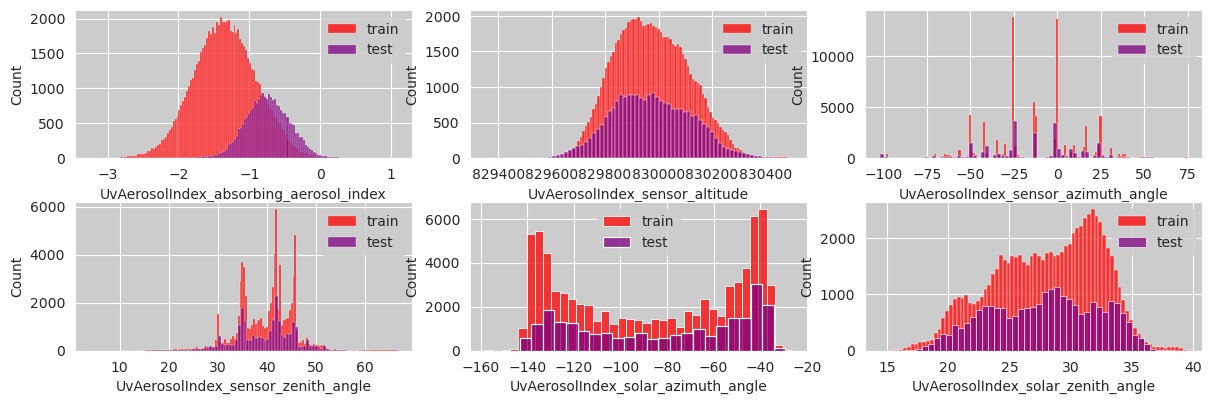

In [30]:
# Distribution of UvAerosolIndex columns
plot_dist(pollutants['UVAI'])

### Ozone

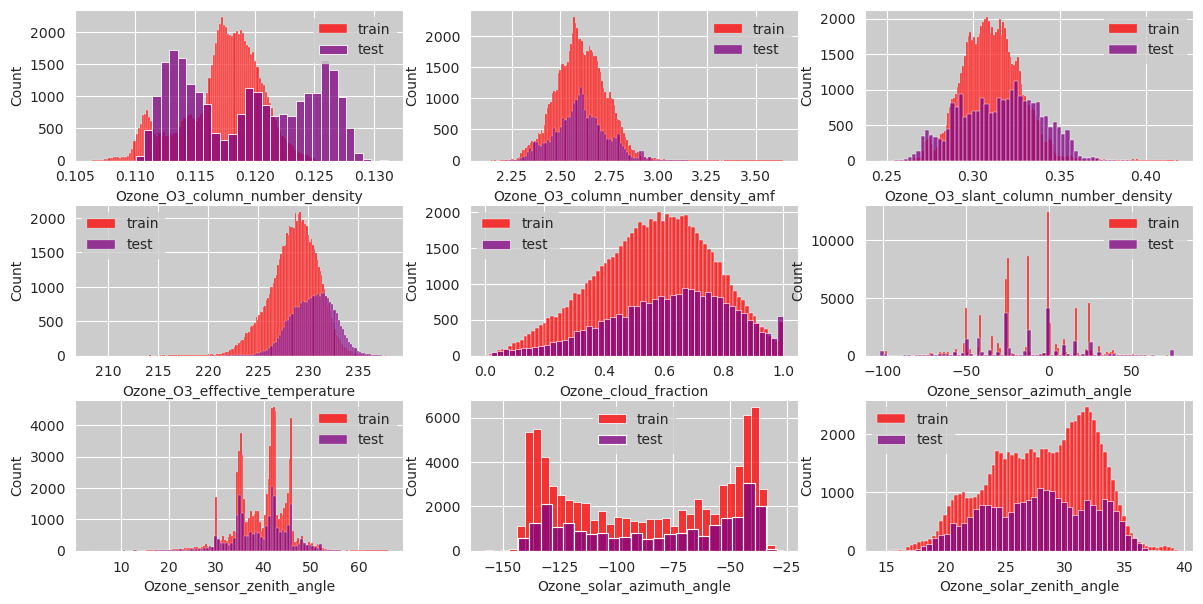

In [31]:
# Distribution of O3 columns
plot_dist(pollutants['O3'])

### Cloud

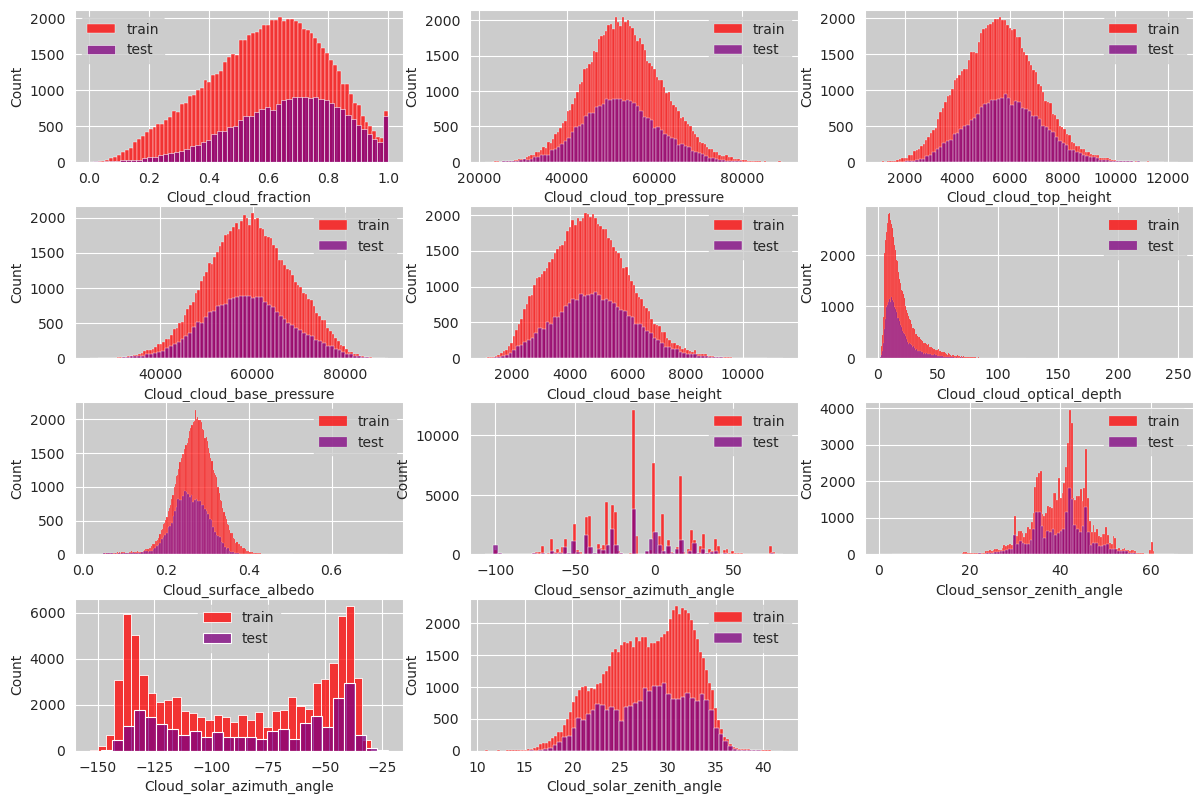

In [32]:
# Distribution of Cloud columns
plot_dist(pollutants['CLD'])

### Observation:
#### Most of the distributions look similar for train and test data. The ones that have a significant difference are:
- NitrogenDioxide_stratospheric_NO2_column_number_density
- NitrogenDioxide_absorbing_aerosol_index
- UvAerosolIndex_absorbing_aerosol_index
- Ozone_O3_column_number_density

# Modeling without imputing null values 

In [33]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split, LeaveOneGroupOut
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna

In [34]:
# Define evaluation metric RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.sum((y_true - y_pred)**2) / len(y_true))

In [35]:
# Separating out feature and label columns
X = train.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis=1)
y = train.emission
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

We will first explore the HistGradientBoostingRegressor or the **Histogram-based Gradient Boosting Regression Tree** which is much faster than GradientBoostingRegressor for large datasets and also accepts null values without the need for preprocessing. 

In [36]:
# Build a baseline model
model = HistGradientBoostingRegressor(random_state=14)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse(y_test, preds)

28.623274346413684

It gives a RMSE score of 28.62 which is neither great nor bad. This score will be the baseline for further model training.

## Hyperparameter optimization using Optuna
We will use LeaveOneGroupOut cross validation technique to train model on 2 years and test on the one that is left out. This way the model will be tested on all 3 years without overfitting.

In [37]:
def objective(trial):
    
    params = {
        "max_iter": trial.suggest_int("max_iter", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "l2_regularization": trial.suggest_float("l2_regularization", 1, 10, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100)
    }
    
    # Train models separately for each year
    years = [2019, 2020, 2021]
    scores = []
    
    # Split into train and test sets based on year
    logo = LeaveOneGroupOut()
    for i, (train_index, test_index) in enumerate(logo.split(X, y, X['year'])):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        # Fit the model and calculate RMSE
        HGBR_model = HistGradientBoostingRegressor(**params)
        HGBR_model.fit(X_train, y_train)
        preds = HGBR_model.predict(X_test)
        
        score = rmse(y_test, preds)
        scores.append(score)
    
    # Evaluate predictions
    return np.mean(scores)

In [38]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-11-13 16:39:56,708] A new study created in memory with name: no-name-34874824-69d8-4ca1-bf2d-978fad304bdb
[I 2023-11-13 16:40:19,207] Trial 0 finished with value: 46.037409127621196 and parameters: {'max_iter': 282, 'learning_rate': 0.028061713985921086, 'max_depth': 7, 'l2_regularization': 3.085074586131244, 'min_samples_leaf': 6, 'max_leaf_nodes': 40}. Best is trial 0 with value: 46.037409127621196.
[I 2023-11-13 16:40:28,970] Trial 1 finished with value: 71.98662858900464 and parameters: {'max_iter': 249, 'learning_rate': 0.022318265302253337, 'max_depth': 7, 'l2_regularization': 1.0588087882378798, 'min_samples_leaf': 32, 'max_leaf_nodes': 10}. Best is trial 0 with value: 46.037409127621196.
[I 2023-11-13 16:41:15,254] Trial 2 finished with value: 51.479414117184525 and parameters: {'max_iter': 337, 'learning_rate': 0.011966575642164625, 'max_depth': 9, 'l2_regularization': 1.524667491105798, 'min_samples_leaf': 32, 'max_leaf_nodes': 90}. Best is trial 0 with value: 46.0374

In [39]:
# Choose the best set of hyperparams
def results_optuna(study):
    print('Number of finished trials:', len(study.trials))
    trial = study.best_trial
    print('Best trial value:', trial.value)
    print('Best Params:', study.best_params)
    return study.best_params

best_params = results_optuna(study)

Number of finished trials: 10
Best trial value: 37.13324501169623
Best Params: {'max_iter': 344, 'learning_rate': 0.020330885098722995, 'max_depth': 10, 'l2_regularization': 7.065982145338165, 'min_samples_leaf': 8, 'max_leaf_nodes': 67}


In [40]:
best_model = HistGradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)
best_preds = best_model.predict(X_test)
rmse(y_test, best_preds)

28.559769107909624

Hyperparameter tuning helped in reducing the RMSE score a little bit but this is still not great and our model is overfitting the train data. Let's dive into some feature engineering to make better predictions.

# Feature Engineering

From our previous analysis we know that Cloud, Ozone and UVAersolIndex columns have less than 1% non-null values so they can be useful for model training.

In [41]:
def feature_engg(df, type='train'):
    # Select features with more than 99% non-null values 
    useful_features = ['UvAerosolIndex_absorbing_aerosol_index',
                    'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle',
                    'UvAerosolIndex_sensor_zenith_angle',
                    'UvAerosolIndex_solar_azimuth_angle',
                    'UvAerosolIndex_solar_zenith_angle', 'Ozone_O3_column_number_density',
                    'Ozone_O3_column_number_density_amf',
                    'Ozone_O3_slant_column_number_density',
                    'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
                    'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle',
                    'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle',
                    'Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
                    'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
                    'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
                    'Cloud_surface_albedo', 'Cloud_sensor_azimuth_angle',
                    'Cloud_sensor_zenith_angle', 'Cloud_solar_azimuth_angle',
                    'Cloud_solar_zenith_angle']

    if type == 'test':
        df = df[['latitude', 'longitude', 'year', 'week_no'] + useful_features]
    else:
        df = df[['latitude', 'longitude', 'year', 'week_no', 'emission'] + useful_features]
        
    # Create additional features  
    df['month'] = df['week_no']//4
    df['week_no_sin'] = np.sin(2*np.pi*df['week_no']/52)
    df['week_no_cos'] = np.cos(2*np.pi*df['week_no']/52)
    df['rot_30'] = np.cos(np.pi/6) * df['latitude'] + np.sin(np.pi/6) * df['longitude']
    df['rot_60'] = np.cos(np.pi/3) * df['latitude'] + np.sin(np.pi/3) * df['longitude']
    
    coords = df[['latitude', 'longitude']].values
    pca = PCA().fit(coords)
    df['pca_x'] = pca.transform(df[['latitude', 'longitude']])[:,0]
    df['pca_y'] = pca.transform(df[['latitude', 'longitude']])[:,1]
    
#     cluster_df = df.groupby(['latitude', 'longitude'], as_index=False)['emission'].mean() 
#     cluster_df['dbscan'] = DBSCAN().fit_predict(cluster_df) 
#     cluster_df.drop('emission', axis=1, inplace=True)
#     df = df.merge(cluster_df, on=['latitude', 'longitude'])
        
    return df

In [42]:
train_df = feature_engg(train, type='train')
train_df

,latitude,longitude,year,week_no,emission,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,...,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,month,week_no_sin,week_no_cos,rot_30,rot_60,pca_x,pca_y
0,-0.510,29.290,2019,0,3.750994,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,...,35.632416,-138.786423,30.752140,0,0.000000e+00,1.000000,14.203327,25.110884,-0.141790,1.495172
1,-0.510,29.290,2019,1,4.025176,-1.548119,829747.856973,16.152492,43.485327,-142.786141,...,39.557633,-145.183930,27.251779,0,1.205367e-01,0.992709,14.203327,25.110884,-0.141790,1.495172
2,-0.510,29.290,2019,2,4.231381,-1.038673,829892.960629,-41.557633,41.269033,-135.364627,...,30.401823,-142.519545,26.193296,0,2.393157e-01,0.970942,14.203327,25.110884,-0.141790,1.495172
3,-0.510,29.290,2019,3,4.305286,-0.626435,829794.848214,-0.001270,34.458740,-137.489602,...,24.380357,-132.665828,28.829155,0,3.546049e-01,0.935016,14.203327,25.110884,-0.141790,1.495172
4,-0.510,29.290,2019,4,4.347317,-1.584896,829736.142857,-0.604325,41.794705,-136.448518,...,37.392979,-141.509805,22.204612,1,4.647232e-01,0.885456,14.203327,25.110884,-0.141790,1.495172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,29.404171,-1.017330,830256.625375,-35.142825,40.093391,-129.949217,...,40.113533,-129.935508,32.095214,12,-4.647232e-01,0.885456,12.293482,24.591936,0.303341,-1.437830
79019,-3.299,30.301,2021,49,29.186497,-1.575399,830194.790526,-13.034698,42.519018,-133.307545,...,47.528435,-134.252871,30.771469,12,-3.546049e-01,0.935016,12.293482,24.591936,0.303341,-1.437830
79020,-3.299,30.301,2021,50,29.131205,-0.855705,830174.000296,-0.346926,35.359190,-134.750981,...,35.328098,-134.731723,30.716166,12,-2.393157e-01,0.970942,12.293482,24.591936,0.303341,-1.437830
79021,-3.299,30.301,2021,51,28.125792,-1.232358,830032.493363,8.424284,48.277884,-139.470709,...,48.295652,-139.447849,29.112868,12,-1.205367e-01,0.992709,12.293482,24.591936,0.303341,-1.437830


# Modeling with additional features

In [43]:
X = train_df.drop('emission', axis=1)
y = train_df['emission']

In [44]:
def objective_xgb(trial):
    
    # XGBoost params
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'max_delta_step': trial.suggest_float('max_delta_step', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'rmse'
    }
    
    years = [2019, 2020, 2021]
    scores = []
    
    # Split into train and test sets based on year
    logo = LeaveOneGroupOut()
    for i, (train_index, test_index) in enumerate(logo.split(X, y, X['year'])):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        # Fit the model and calculate RMSE
        xgb = XGBRegressor(**xgb_params)
        xgb.fit(X_train, y_train)
        xgb_preds = xgb.predict(X_test)
        
        score = rmse(y_test, xgb_preds)
        scores.append(score)
    
    # Evaluate predictions
    return np.mean(scores)

In [45]:
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(objective_xgb, n_trials=10)

[I 2023-11-13 16:43:54,244] A new study created in memory with name: no-name-d5835a16-38b4-4d6f-93b4-7874c6464627
[I 2023-11-13 16:44:20,574] Trial 0 finished with value: 133.2333771912533 and parameters: {'max_depth': 1, 'learning_rate': 0.04137173032011513, 'n_estimators': 494, 'min_child_weight': 5, 'subsample': 0.17406129072765114, 'colsample_bytree': 0.8767665438675238, 'reg_alpha': 2.348524850765129e-08, 'reg_lambda': 0.00032278607989462253}. Best is trial 0 with value: 133.2333771912533.
[I 2023-11-13 16:44:52,741] Trial 1 finished with value: 100.6684196639656 and parameters: {'max_depth': 2, 'learning_rate': 0.017164249602896035, 'n_estimators': 228, 'min_child_weight': 7, 'subsample': 0.8776994999608415, 'colsample_bytree': 0.4240408558874869, 'reg_alpha': 0.011015221940832137, 'reg_lambda': 4.088076652555789e-06}. Best is trial 1 with value: 100.6684196639656.
[I 2023-11-13 16:45:22,497] Trial 2 finished with value: 325.29558137077225 and parameters: {'max_depth': 6, 'learni

In [46]:
best_params_xgb = results_optuna(xgb_study)

Number of finished trials: 10
Best trial value: 62.107755955707965
Best Params: {'max_depth': 8, 'learning_rate': 0.04579105174294369, 'n_estimators': 142, 'min_child_weight': 8, 'subsample': 0.6407068898319714, 'colsample_bytree': 0.06686673171944954, 'reg_alpha': 2.8064306824843483e-07, 'reg_lambda': 0.010733229469611966}


In [47]:
# # Test on validation set
# xgb = XGBRegressor(**best_params_xgb)
# xgb.fit(X_train, y_train)
# xgb_preds = xgb.predict(X_test)
# rmse(y_test, xgb_preds)

In [48]:
# # Get feature importances
# importances = xgb.feature_importances_
# feature_names = X_train.columns
# sorted_features = sorted(zip(importances, feature_names))
# sorted_importances, sorted_feature_names = zip(*sorted_features)

# # Create a bar plot of feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('XGBoost Feature Importances')
# plt.show()

# Make predictions

In [49]:
# Preprocess test set
test_df = feature_engg(test, type='test')
test_df

,latitude,longitude,year,week_no,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,...,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,month,week_no_sin,week_no_cos,rot_30,rot_60,pca_x,pca_y
0,-0.510,29.290,2022,0,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,...,33.697044,-133.047546,33.779583,0,0.000000,1.000000,14.203327,25.110884,-0.141790,1.495172
1,-0.510,29.290,2022,1,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,...,42.402593,-138.632822,31.012380,0,0.120537,0.992709,14.203327,25.110884,-0.141790,1.495172
2,-0.510,29.290,2022,2,-1.034709,829642.010417,15.736805,42.092969,-142.989044,27.440719,...,45.936480,-144.784988,26.743361,0,0.239316,0.970942,14.203327,25.110884,-0.141790,1.495172
3,-0.510,29.290,2022,3,-0.641272,829800.856545,-24.466617,42.147727,-135.011886,29.596561,...,42.140419,-135.027891,29.604774,0,0.354605,0.935016,14.203327,25.110884,-0.141790,1.495172
4,-0.510,29.290,2022,4,-0.712758,829761.772395,-12.909506,30.140668,-135.499142,26.273346,...,30.122641,-135.500119,26.276807,1,0.464723,0.885456,14.203327,25.110884,-0.141790,1.495172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24348,-3.299,30.301,2022,44,-0.558726,830202.277703,-25.530489,45.253230,-116.538328,29.990217,...,45.284576,-116.521412,29.992562,11,-0.822984,0.568065,12.293482,24.591936,0.303341,-1.437830
24349,-3.299,30.301,2022,45,-0.909833,830153.126242,-13.383884,43.766636,-122.419972,29.009699,...,43.770351,-122.405759,29.017975,11,-0.748511,0.663123,12.293482,24.591936,0.303341,-1.437830
24350,-3.299,30.301,2022,46,-1.217974,830193.462500,4.243346,30.612465,-125.358314,29.259308,...,33.226455,-124.530639,30.187472,11,-0.663123,0.748511,12.293482,24.591936,0.303341,-1.437830
24351,-3.299,30.301,2022,47,-0.868209,830189.098214,-0.669880,45.870072,-129.009204,30.426114,...,45.885617,-129.006797,30.427455,11,-0.568065,0.822984,12.293482,24.591936,0.303341,-1.437830


In [50]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X, y)
predictions = xgb.predict(test_df)
predictions

array([53.620506, 27.439615, 21.33833 , ..., 44.883614, 39.71028 ,
       33.686398], dtype=float32)